In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import plotly.express as px
import ast
import pickle
import warnings
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
warnings.filterwarnings('ignore')

In [ ]:
df=pd.read_csv('../data/processed/preprocessed.csv')

# Preparing data for modeling

In [17]:
df.head()

,Insurance,Fuel Type,Seats,Transmission,Power in bhp,Mileage in kmpl or km/kg,new_vehical_price_in_lakh_inr,Engine Displacement in cc,Registration age,Year of Manufacture age,...,Swift Dzire LDI,Celerio ZXI MT BSIV,XUV500 W8 FWD,Bolero ZLX,Wagon R LXI,Seltos GTX Plus,City i VTEC CVT VX,Baleno Alpha,Swift VXI BSII,Xcent 1.1 CRDi Base
0,No Insurance,Diesel,5,Manual,67.04,23.59,8.05,1364.0,12.61,12.61,...,0,0,0,0,0,0,0,0,0,0
1,No Insurance,Petrol,5,Manual,88.50,22.35,11.28,1197.0,1.60,1.60,...,0,0,0,0,0,0,0,0,0,0
2,Comprehensive,Diesel,5,Manual,88.70,22.10,11.86,1396.0,8.61,8.61,...,0,0,0,0,0,0,0,0,0,0
3,No Insurance,Diesel,5,Manual,103.60,20.54,10.05,1598.0,14.61,14.61,...,0,0,0,0,0,0,0,0,0,0
4,No Insurance,Diesel,5,Manual,126.30,22.32,11.87,1582.0,11.61,11.61,...,0,0,0,0,0,0,0,0,0,0


In [24]:
df['Registration age']=pd.to_datetime(df['Registration Year '],format='%Y').apply(lambda x:round((datetime.now().date()-x.date()).days/365,2))
df['Year of Manufacture age']=pd.to_datetime(df['Year of Manufacture '],format='%Y').apply(lambda x:round((datetime.now().date()-x.date()).days/365,2))

In [6]:
df['Kms Driven in 1000 km']=df['Kms Driven ']/1000

In [7]:
# fit part
df['other_features']=df['other_features'].apply(ast.literal_eval)
add_features=[]
for i in df['other_features'].values:
    add_features+=i
add_features=list(set(add_features))

# for streamlit webapp
with open('../data/processed/add_features.pkl',"wb") as f:
    pickle.dump(add_features,f)
for feature in add_features:
    df[feature]=[0 for i in range(df.shape[0])]

In [8]:
# transform part
for feature in add_features:
    for i in range(df.shape[0]):
        if feature in df.loc[i,'other_features']:
            df.loc[i,feature]=1

In [9]:
# fit part
val_cnt=df['RTO '].value_counts()
for val,ind in zip(val_cnt.values,val_cnt.index):
    if val<21:
        val_cnt.loc['Others']+=val
        val_cnt.drop(ind,inplace=True)

# for streamlit webapp
with open('../data/processed/rto.pkl',"wb") as f:
    pickle.dump(val_cnt.index,f)
for rto in val_cnt.index:
    df[rto]=[0 for i in range(df.shape[0])]

In [10]:
# transform
for rto in val_cnt.index:
    for i in range(df.shape[0]):
        if rto==df.loc[i,'RTO ']:
            df.loc[i,rto]=1

In [11]:
df['Seats ']=df['Seats '].apply(lambda x:int(x.replace('Seats','').strip()))

In [12]:
d = {
    "First": 1,
    "Second": 2,
    "Third": 3,
    "Fourth": 4,
    "Fifth": 5,
    "Sixth": 6,
    "Seventh": 7,
    "Eighth": 8,
    "Ninth": 9,
    "Tenth": 10
}

def transform_owner(txt):
    return d[txt.replace('Owner','').strip()]
df['No of owners']=df['Ownership '].apply(transform_owner)

In [13]:
# fit part
companies=[]
for i in df['company_name'].values:
    companies.append(i)
companies=list(set(companies))

# for streamlit webapp
with open('../data/processed/companies.pkl',"wb") as f:
    pickle.dump(companies,f)
for comp in companies:
    df[comp]=[0 for i in range(df.shape[0])]

In [14]:
# transform
for comp in tqdm(companies):
    for i in range(df.shape[0]):
        if comp==df.loc[i,'company_name']:
            df.loc[i,comp]=1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.32it/s]


In [15]:
models={}
for i in df['model_detail'].values:
    models[i]=models.get(i,0)+1

major_models=['other_model']   
for model in models.keys():
    if(models[model]>10):
        major_models.append(model)

# for streamlit webapp
with open('../data/processed/car_models.pkl',"wb") as f:
    pickle.dump(major_models,f)
for model in major_models:
    df[model]=[0 for i in range(df.shape[0])]
df['other_model']=[0 for i in range(df.shape[0])]

In [16]:
# transform
for model in tqdm(major_models):
    for i in range(df.shape[0]):
        if model==df.loc[i,'model_detail']:
            df.loc[i,model]=1
        else:
            df.loc[i,'other_model']=1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 166/166 [18:52<00:00,  6.82s/it]


In [17]:
df.drop(columns=['Registration Year ','Year of Manufacture ','Kms Driven ','RTO ','other_features','Ownership ','company_name','model_detail'],axis=1,inplace=True)

In [32]:
df.to_csv('../data/processed/data_for_pipeline.csv',index=False)

<Axes: >

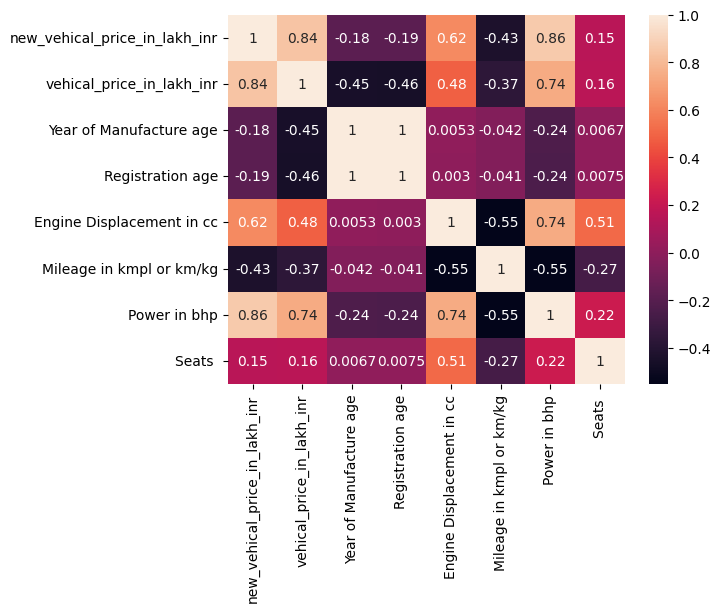

In [24]:
sns.heatmap(df[['new_vehical_price_in_lakh_inr','vehical_price_in_lakh_inr','Year of Manufacture age','Registration age','Engine Displacement in cc','Mileage in kmpl or km/kg','Power in bhp','Seats ']].corr(),annot=True)

# normalising distribution

## Power

In [89]:
fn=PowerTransformer('yeo-johnson')

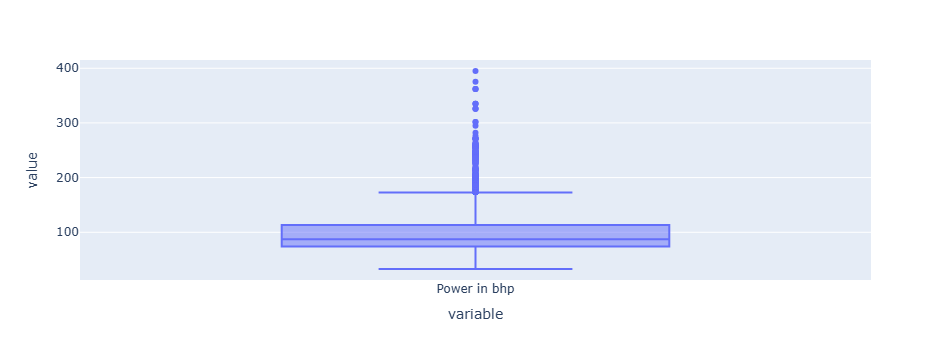

In [51]:
px.box(df['Power in bhp'])

(<Axes: xlabel='Power in bhp', ylabel='Density'>,
 np.float64(1.6485705128720074))

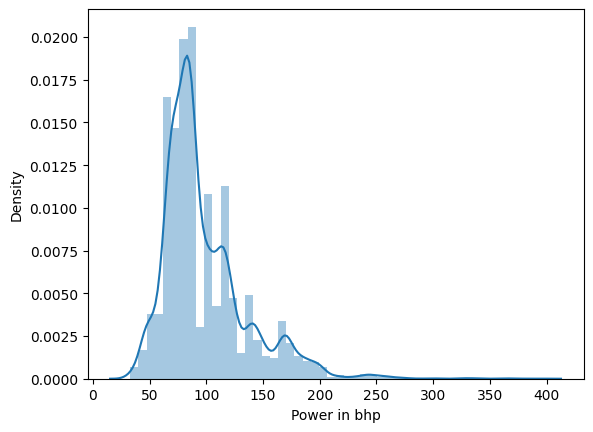

In [54]:
sns.distplot(df['Power in bhp'])

In [55]:
df['Power in bhp'].skew()

np.float64(1.6485705128720074)

In [135]:
Power_log=df['Power in bhp'].apply(np.log1p)

In [136]:
pd.DataFrame(Power_log).skew()

Power in bhp    0.448872
dtype: float64

<Axes: xlabel='Power in bhp', ylabel='Density'>

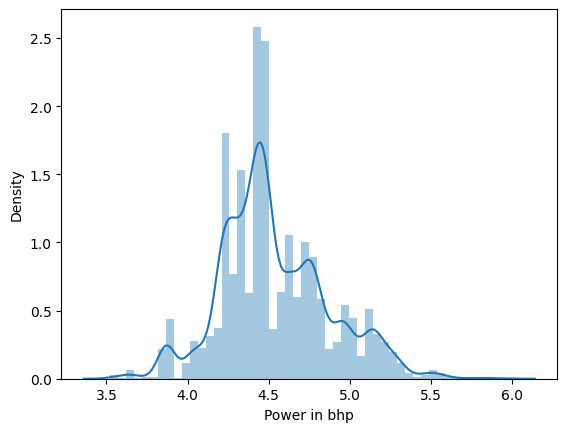

In [137]:
sns.distplot(Power_log)

## Mileage

<Axes: xlabel='Mileage in kmpl or km/kg', ylabel='Density'>

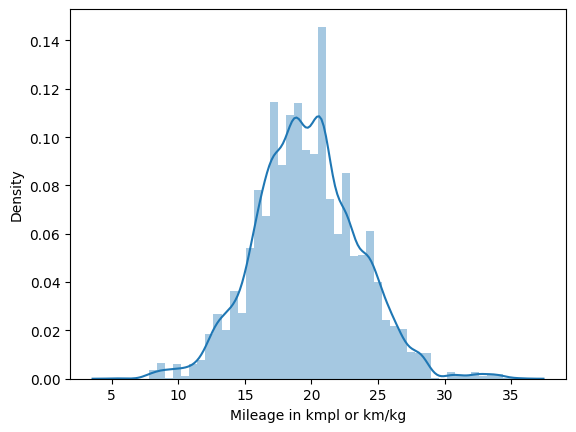

In [59]:
sns.distplot(df['Mileage in kmpl or km/kg'])

In [60]:
df['Mileage in kmpl or km/kg'].skew()

np.float64(0.16870721030939925)

## new vehical price

In [61]:
df['new_vehical_price_in_lakh_inr'].skew()

np.float64(4.37829399813164)

<Axes: xlabel='new_vehical_price_in_lakh_inr', ylabel='Density'>

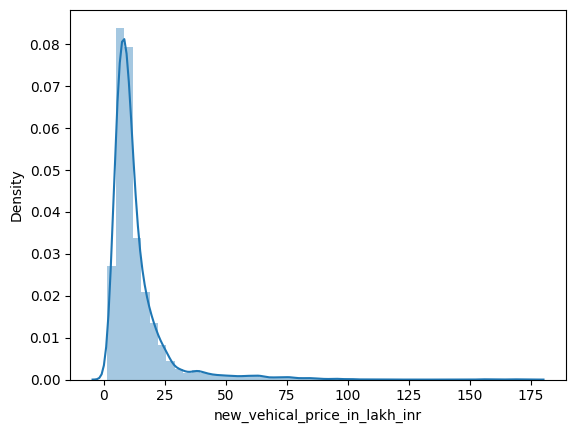

In [62]:
sns.distplot(df['new_vehical_price_in_lakh_inr'])

In [63]:
new_price_log=df['new_vehical_price_in_lakh_inr'].apply(np.log1p)

<Axes: xlabel='new_vehical_price_in_lakh_inr', ylabel='Density'>

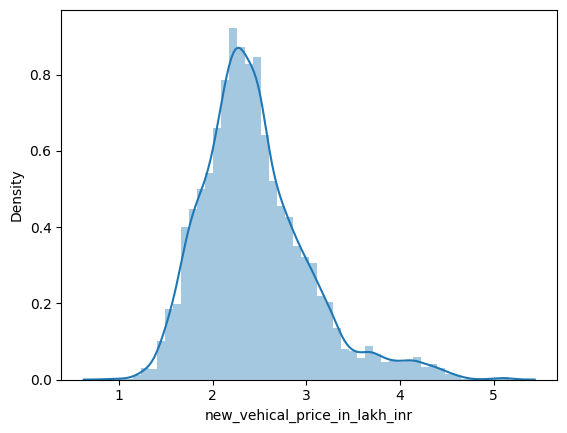

In [64]:
sns.distplot(new_price_log)

In [65]:
new_price_log.skew()

np.float64(1.002304283964035)

## Engine Displacement in cc

In [66]:
df['Engine Displacement in cc'].skew()

np.float64(1.3808987899496694)

<Axes: xlabel='Engine Displacement in cc', ylabel='Density'>

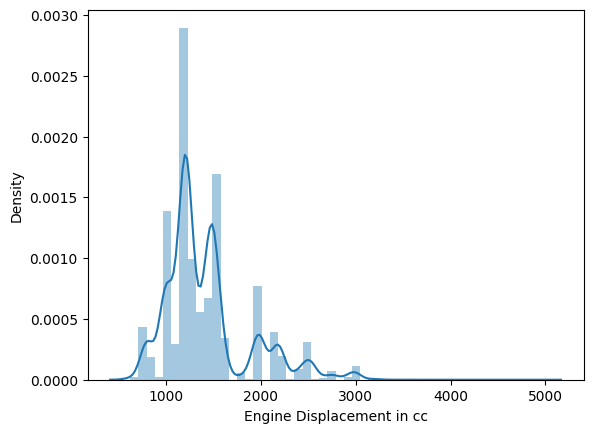

In [67]:
sns.distplot(df['Engine Displacement in cc'])

In [70]:
engine_disp_log=df['Engine Displacement in cc'].apply(np.log1p)

In [71]:
engine_disp_log.skew()

np.float64(0.5541610125521933)

<Axes: xlabel='Engine Displacement in cc', ylabel='Density'>

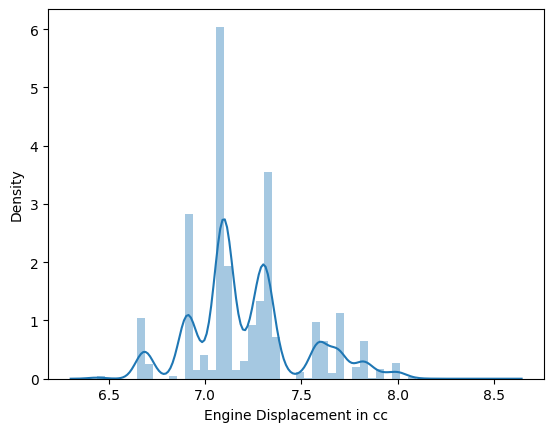

In [72]:
sns.distplot(engine_disp_log)

## Registration age	

In [73]:
df['Registration age'].skew()

np.float64(0.43225637077578694)

<Axes: xlabel='Registration age', ylabel='Density'>

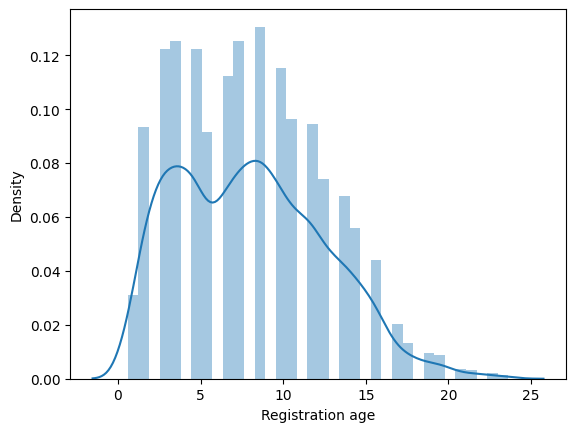

In [74]:
sns.distplot(df['Registration age'])

## Kms Driven 

In [75]:
df['Kms Driven in 1000 km'].skew()

np.float64(75.23766607395655)

<Axes: xlabel='Kms Driven in 1000 km', ylabel='Density'>

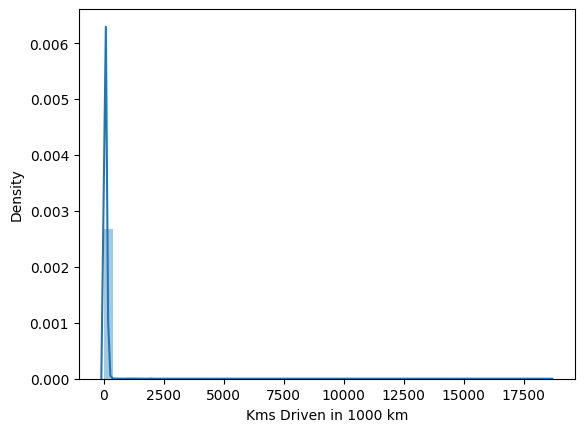

In [76]:
sns.distplot(df['Kms Driven in 1000 km'])

In [84]:
kms_log=fn.fit_transform(df[['Kms Driven in 1000 km']])

In [86]:
pd.DataFrame(kms_log).skew()

0    0.189407
dtype: float64

<Axes: ylabel='Density'>

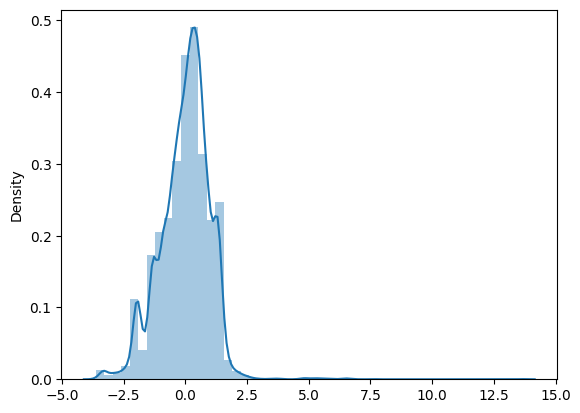

In [87]:
sns.distplot(kms_log)

In [130]:
# i am converting my kms col into bins
from sklearn.preprocessing import KBinsDiscretizer
kb=KBinsDiscretizer(n_bins=5,encode='ordinal',strategy='quantile')
kms_disc=kb.fit_transform(df[['Kms Driven in 1000 km']]*1000)

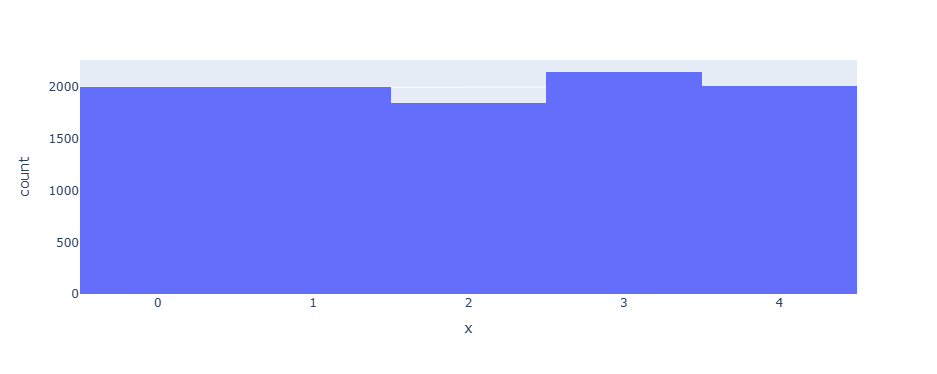

In [134]:
px.histogram(x=kms_disc.ravel())

# Final pipeline

In [2]:
df=pd.read_csv('../data/processed/data_for_pipeline.csv')

In [156]:
df=df.sample(1000,random_state=42)

In [3]:
y=df[['vehical_price_in_lakh_inr']]
df.drop(columns='vehical_price_in_lakh_inr',axis=1,inplace=True)
cat_columns=['Insurance ','Fuel Type ','Transmission ']

In [4]:
other_cols=[]
to_norm=['Seats ','Mileage in kmpl or km/kg','Power in bhp','new_vehical_price_in_lakh_inr','Engine Displacement in cc','Registration age','Year of Manufacture age','Kms Driven in 1000 km']
for col in df.columns:
    if col not in to_norm:
        other_cols.append(col)

In [5]:
df_arranged=pd.DataFrame()
df_arranged[to_norm]=df[to_norm]
df_arranged[cat_columns]=df[cat_columns]
df_arranged[other_cols]=df[other_cols]

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import PCA

clm=ColumnTransformer(
    [
    ('ins',OneHotEncoder(),[8,9,10]),
    ('log',FunctionTransformer(func=np.log1p),[2,3,4]),
    ('pow',PowerTransformer('box-cox'),[7])
    ],remainder='passthrough'
)

In [7]:
clm_desc=ColumnTransformer(
    [
    ('ins',OneHotEncoder(),[8,9,10]),
    ('log',FunctionTransformer(func=np.log1p),[2,3,4]),
    ('pow',KBinsDiscretizer(n_bins=5,encode='ordinal',strategy='quantile'),[7])
    ],remainder='passthrough'
)

In [8]:
clm_norm=ColumnTransformer(
    [
        ('norm',MinMaxScaler(),[i for i in range(8)])
    ],remainder='passthrough'
)
clm_norm_desc=ColumnTransformer(
    [
        ('norm',MinMaxScaler(),[i for i in range(7)])
    ],remainder='passthrough'
)

In [9]:
clm_std=ColumnTransformer(
    [
        ('norm',StandardScaler(),[i for i in range(8)])
    ],remainder='passthrough'
)
clm_std_desc=ColumnTransformer(
    [
        ('norm',StandardScaler(),[i for i in range(7)])
    ],remainder='passthrough'
)

In [10]:
ppl_desc=Pipeline([
    ('clm',clm_desc)
])

ppl_desc_norm=Pipeline([
    ('clm',clm_desc),
    ('norm',clm_norm_desc)
])

ppl_desc_std=Pipeline([
    ('clm',clm_desc),
    ('std',clm_std_desc)
])

In [11]:
ppl=Pipeline([
    ('clm',clm)
])

ppl_norm=Pipeline([
    ('clm',clm),
    ('norm',clm_norm)
])

ppl_std=Pipeline([
    ('clm',clm),
    ('std',clm_std)
])

In [12]:
X_desc=ppl_desc.fit_transform(df_arranged)
X_desc_norm=ppl_desc_norm.fit_transform(df_arranged)
X_desc_std=ppl_desc_std.fit_transform(df_arranged)

X=ppl.fit_transform(df_arranged)
X_norm=ppl_norm.fit_transform(df_arranged)
X_std=ppl_std.fit_transform(df_arranged)

# Model

## RandomForest Regressor

In [14]:
all_X=[X,X_norm,X_std,X_desc,X_desc_norm,X_desc_std]
var_names = ["X", "X_norm", "X_std", "X_desc", "X_desc_norm", "X_desc_std"]

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error

rf=RandomForestRegressor(max_depth=9,n_estimators=50,bootstrap=True,criterion='absolute_error')

for i in range(len(all_X)):
    score=cross_val_score(rf,X=all_X[i],y=y,n_jobs=-1)
    print(var_names[i],score.mean(),score.max())

X 0.9234731787031206 0.9479748474177949


In [141]:
from sklearn.model_selection import cross_val_score
import optuna

# Define the objective function
def objective(trial):
    # Suggest values for the hyperparameters
    n_estimators_ = trial.suggest_int('n_estimators', 10, 200)
    max_depth_ = trial.suggest_int('max_depth', 3, 25)
    max_features_ = trial.suggest_float('max_features', 0, 1)
    max_samples_ = trial.suggest_float('max_samples', 0, 1)
    bootstrap_=trial.suggest_categorical('bootstrap',[True,False])
    crietion_=trial.suggest_categorical('criterion',["squared_error","absolute_error",'friedman_mse'])
    # Create the RandomForestClassifier with suggested hyperparameters
    model=None

    if  bootstrap_:
        model = RandomForestRegressor(
            n_estimators=n_estimators_,
            max_depth=max_depth_,
            max_samples=max_samples_,
            max_features=max_features_,
            bootstrap=bootstrap_,
            criterion=crietion_,
            random_state=42
        )
    else:
        model = RandomForestRegressor(
            n_estimators=n_estimators_,
            max_depth=max_depth_,
            max_features=max_features_,
            bootstrap=bootstrap_,
            criterion=crietion_,
            random_state=42
        )
        
    # Perform 3-fold cross-validation and calculate accuracy
    score = cross_val_score(model, X=X_desc, y=y, cv=5,n_jobs=-1).mean()

    return score  # Return the accuracy score for Optuna to maximize
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())  # We aim to maximize accuracy
study.optimize(objective, n_trials=100,n_jobs=-1)  # Run 50 trials to find the best hyperparameters

[I 2025-08-11 14:47:02,333] A new study created in memory with name: no-name-9b71e6c2-0d23-410f-bd5f-da0a69862d0d
[I 2025-08-11 14:47:10,355] Trial 1 finished with value: 0.6756897431786063 and parameters: {'n_estimators': 31, 'max_depth': 24, 'max_features': 0.954289392107616, 'max_samples': 0.9193127201831095, 'bootstrap': False, 'criterion': 'squared_error'}. Best is trial 1 with value: 0.6756897431786063.
[I 2025-08-11 14:47:41,115] Trial 7 finished with value: 0.7516334185714861 and parameters: {'n_estimators': 160, 'max_depth': 7, 'max_features': 0.6289862020730078, 'max_samples': 0.5751995922519895, 'bootstrap': False, 'criterion': 'friedman_mse'}. Best is trial 7 with value: 0.7516334185714861.
[I 2025-08-11 14:47:43,836] Trial 8 finished with value: 0.6206666801240824 and parameters: {'n_estimators': 55, 'max_depth': 8, 'max_features': 0.5019814734063474, 'max_samples': 0.08428483423844935, 'bootstrap': True, 'criterion': 'friedman_mse'}. Best is trial 7 with value: 0.75163341

KeyboardInterrupt: 

[I 2025-08-11 14:56:37,713] Trial 35 finished with value: 0.7916316867033396 and parameters: {'n_estimators': 16, 'max_depth': 18, 'max_features': 0.4028030371968562, 'max_samples': 0.6571937173045463, 'bootstrap': False, 'criterion': 'absolute_error'}. Best is trial 12 with value: 0.8036469435181879.
[I 2025-08-11 14:57:25,428] Trial 32 finished with value: 0.800036953732219 and parameters: {'n_estimators': 172, 'max_depth': 18, 'max_features': 0.3764864894434283, 'max_samples': 0.6084338168477444, 'bootstrap': False, 'criterion': 'absolute_error'}. Best is trial 12 with value: 0.8036469435181879.
[I 2025-08-11 14:57:30,826] Trial 33 finished with value: 0.798081739020936 and parameters: {'n_estimators': 179, 'max_depth': 18, 'max_features': 0.3747455543391778, 'max_samples': 0.6901707020266754, 'bootstrap': False, 'criterion': 'absolute_error'}. Best is trial 12 with value: 0.8036469435181879.


In [102]:
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_slice, plot_contour, plot_param_importances


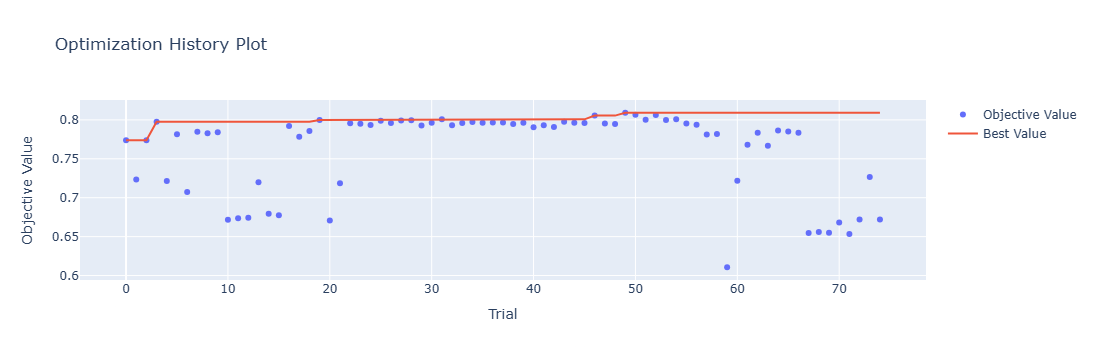

In [103]:
plot_optimization_history(study).show()

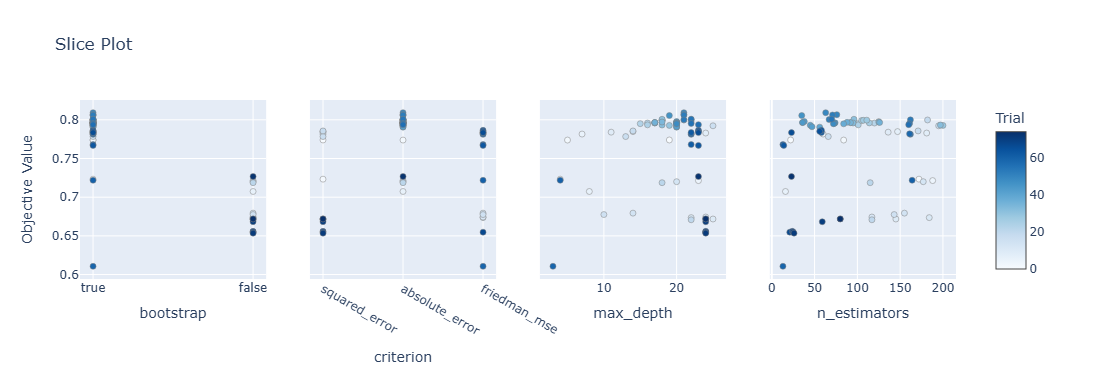

In [104]:
plot_slice(study).show()

In [ ]:
from dvclive import Live
import mlflow

best_trial = study.best_trial

with Live() as live:
    with mlflow.start_run():
        live.log_param('model','gradient_boosting')
        mlflow.log_param('model','gradient_boosting')
        for key,value in best_trial.params.items():
            live.log_param(key,value)
            mlflow.log_param(key,value)
    live.log_metric('cross_val_score/metric',best_trial.value)
    mlflow.log_metric('cross_val_score/metric',best_trial.value)

## SVM

In [96]:
from sklearn.svm import SVR

sv=SVR(kernel='rbf',gamma=0.01,C=60)
for i in range(len(all_X)):
    score=cross_val_score(sv,X=all_X[i],y=y,cv=10)
    print(var_names[i],score.mean(),score.max())

X 0.8147601707805674 0.9382755171431928
X_norm 0.8147601707805674 0.9382755171431928
X_std 0.772086911666134 0.8933826780744378
X_desc 0.45649739220152535 0.6173966339924399
X_desc_norm 0.8151635278539917 0.9206118480269342
X_desc_std 0.7735043633023886 0.8970253997283438


In [136]:
from sklearn.model_selection import cross_val_score
import optuna

# Define the objective function
def objective(trial):
    # Suggest values for the hyperparameters
    kernel_= trial.suggest_categorical('kernel', ['rbf','poly','sigmoid','linear'])
    C_=trial.suggest_int('C',1,100)
    model=None
    gamma_=trial.suggest_float('gamma',0.001,0.1)
    if kernel_!='linear':
        if kernel_=='poly':
            degree_=trial.suggest_int('degree',1,5)
            model=SVR(kernel=kernel_,degree=degree_,gamma=gamma_,C=C_)
        else:
            model=SVR(kernel=kernel_,gamma=gamma_,C=C_)
    else:
        model=SVR(kernel=kernel_,gamma=gamma_,C=C_)
    # Create the RandomForestClassifier with suggested hyperparameters

    # Perform 3-fold cross-validation and calculate accuracy
    score = cross_val_score(model, X=X_norm, y=y, cv=5,n_jobs=-1).mean()

    return score  # Return the accuracy score for Optuna to maximize
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())  # We aim to maximize accuracy
study.optimize(objective, n_trials=150,n_jobs=-1)  # Run 50 trials to find the best hyperparameters

[I 2025-08-10 20:00:37,366] A new study created in memory with name: no-name-819a1827-2dec-4399-99d0-17d1420c63a1
[I 2025-08-10 20:00:38,337] Trial 0 finished with value: -0.05380991646098328 and parameters: {'kernel': 'sigmoid', 'C': 76, 'gamma': 0.06745995460994281}. Best is trial 0 with value: -0.05380991646098328.
[I 2025-08-10 20:01:02,081] Trial 4 finished with value: -0.0538099164607496 and parameters: {'kernel': 'sigmoid', 'C': 99, 'gamma': 0.06823846603228031}. Best is trial 4 with value: -0.0538099164607496.
[I 2025-08-10 20:01:06,427] Trial 2 finished with value: 0.588171184105388 and parameters: {'kernel': 'linear', 'C': 34, 'gamma': 0.09709714137598659}. Best is trial 2 with value: 0.588171184105388.
[I 2025-08-10 20:01:18,087] Trial 5 finished with value: 0.6438329610311643 and parameters: {'kernel': 'linear', 'C': 13, 'gamma': 0.08460536382614835}. Best is trial 5 with value: 0.6438329610311643.
[I 2025-08-10 20:01:37,940] Trial 8 finished with value: 0.6408210485869803 

In [138]:
from dvclive import Live

best_trial = study.best_trial
with Live() as live:
    for key,value in best_trial.params.items():
        live.log_param(key,value)
    clf=SVR(kernel='rbf',gamma=0.05,C=40)
    r2_sc=cross_val_score(clf,X_desc,y)
    live.log_metric('cross_val_score/metric',r2_sc.mean())

	.vscode/settings.json, notebooks/1_preprocessing.ipynb, notebooks/3_model.ipynb


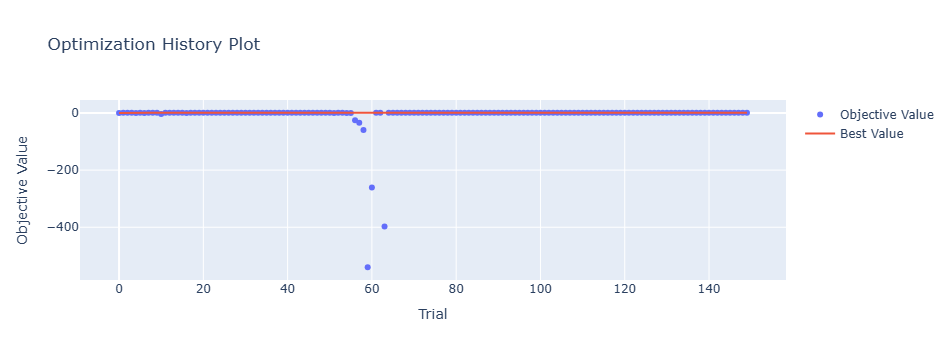

In [139]:
plot_optimization_history(study).show()

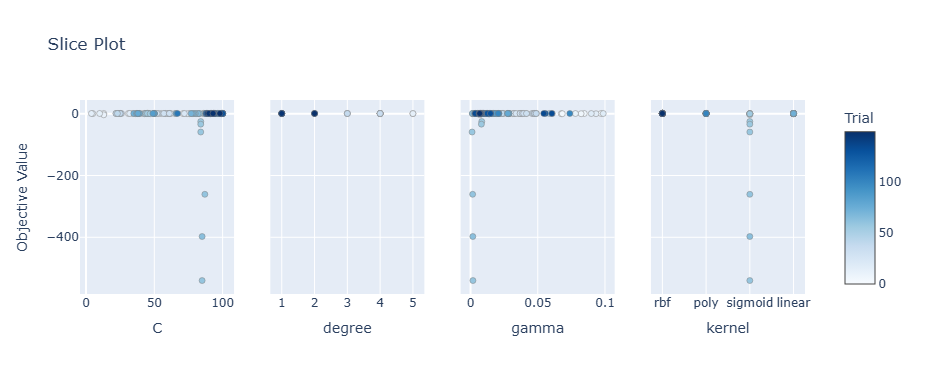

In [140]:
plot_slice(study).show()

## xgboost

In [21]:
import xgboost as xgb

xg=xgb.XGBRegressor(
    max_depth=10,
    n_estimators=77,
    eta=0.8158320121342948,
    device='gpu')

for i in range(len(all_X)):
    score=cross_val_score(xg,X=all_X[i],y=y)
    print(var_names[i],score.mean(),score.max())

X 0.8866511225700379 0.9167893528938293


KeyboardInterrupt: 

In [148]:
from sklearn.model_selection import cross_val_score
import optuna

# Define the objective function
def objective(trial):
    # Suggest values for the hyperparameters
    n_estimators_ = trial.suggest_int('n_estimators', 10, 200)
    max_depth_ = trial.suggest_int('max_depth', 3, 25)
    eta_ = trial.suggest_float('eta', 0.01, 1)
    # gamma_ = trial.suggest_float('lambda', 0, 10)
    # alpha_ = trial.suggest_float('alpha', 0, 10)
    # tree_method_=trial.suggest_categorical('tree_method',['gpu_hist','approx','hist'])
    # process_type_=trial.suggest_categorical('process_type',["default","update"])
    # Create the RandomForestClassifier with suggested hyperparameters
    
    model=xgb.XGBRegressor(
            n_estimators=n_estimators_,
            max_depth=max_depth_,
            eta=eta_,
            # gamma=gamma_,
            # alpha=alpha_,
            # tree_method=tree_method_,
            # process_type=process_type_
        )
    # if tree_method_=='gpu_hist':
    #     model = xgb.XGBRegressor(
    #         device='gpu',
    #         predictor='gpu_predictor',
    #         n_estimators=n_estimators_,
    #         max_depth=max_depth_,
    #         eta=eta_,
    #         # gamma=gamma_,
    #         # alpha=alpha_,
    #         # tree_method=tree_method_,
    #         # process_type=process_type_
    #     )
    # else:
    #     model = xgb.XGBRegressor(
    #         n_estimators=n_estimators_,
    #         max_depth=max_depth_,
    #         eta=eta_,
    #         # gamma=gamma_,
    #         # alpha=alpha_,
    #         # tree_method=tree_method_,
    #         # process_type=process_type_
    #     )

    # Perform 3-fold cross-validation and calculate accuracy
    score = cross_val_score(model, X=X, y=y, cv=5,n_jobs=-1).mean()

    return score  # Return the accuracy score for Optuna to maximize
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())  # We aim to maximize accuracy
study.optimize(objective, n_trials=75,n_jobs=-1)  # Run 50 trials to find the best hyperparameters

[I 2025-08-10 21:04:04,729] A new study created in memory with name: no-name-31d73830-b2b9-4663-b152-080069fe1bc0
[I 2025-08-10 21:04:06,909] Trial 0 finished with value: 0.6825201272964477 and parameters: {'n_estimators': 69, 'max_depth': 13, 'eta': 0.1621114108055061}. Best is trial 0 with value: 0.6825201272964477.
[I 2025-08-10 21:04:09,689] Trial 3 finished with value: 0.711868965625763 and parameters: {'n_estimators': 62, 'max_depth': 10, 'eta': 0.7953625510648775}. Best is trial 3 with value: 0.711868965625763.
[I 2025-08-10 21:04:13,336] Trial 4 finished with value: 0.7368470668792725 and parameters: {'n_estimators': 126, 'max_depth': 18, 'eta': 0.018656340154081255}. Best is trial 4 with value: 0.7368470668792725.
[I 2025-08-10 21:04:14,297] Trial 8 finished with value: 0.6978205561637878 and parameters: {'n_estimators': 70, 'max_depth': 14, 'eta': 0.29034528614680377}. Best is trial 4 with value: 0.7368470668792725.
[I 2025-08-10 21:04:15,211] Trial 11 finished with value: 0.

In [149]:
from dvclive import Live

best_trial = study.best_trial
with Live() as live:
    live.log_param('model','xgboost')
    for key,value in best_trial.params.items():
        live.log_param(key,value)
    live.log_metric('cross_val_score/metric',best_trial.value)

	.vscode/settings.json, notebooks/1_preprocessing.ipynb, notebooks/3_model.ipynb


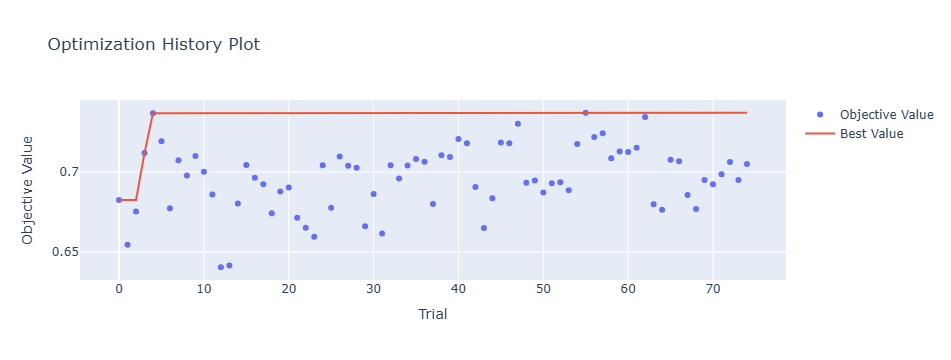

In [150]:
plot_optimization_history(study).show()

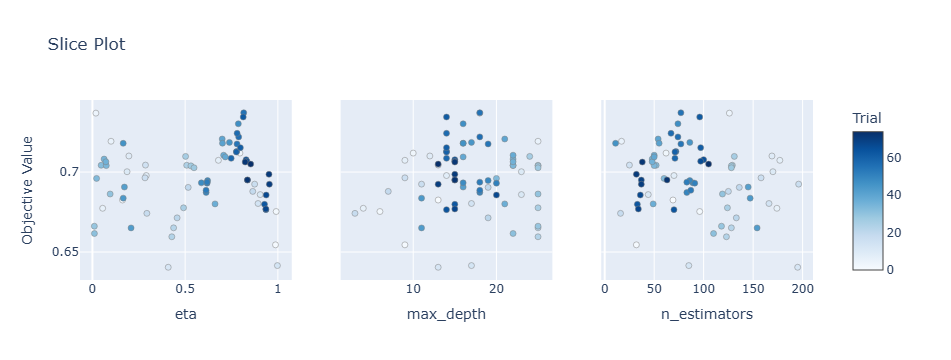

In [151]:
plot_slice(study).show()

## Gradient Boosting

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

gb=GradientBoostingRegressor(criterion='friedman_mse',max_depth=5,n_estimators=128,loss='squared_error',learning_rate=0.4032529036043827)
for i in range(len(all_X)):
    score=cross_val_score(gb,X=all_X[i],y=y)
    print(var_names[i],score.mean(),score.max())

X 0.9268201647656495 0.9471049873943808
X_norm 0.928198109490177 0.9475481875826471
X_std 0.9284331915824033 0.9469011211413396
X_desc 0.9229501704753007 0.9474993049367424
X_desc_norm 0.9224624253237016 0.9483856468340917
X_desc_std 0.9198122905657341 0.9470213368032759


In [196]:
from sklearn.model_selection import cross_val_score
import optuna

# Define the objective function
def objective(trial):
    # Suggest values for the hyperparameters
    n_estimators_ = trial.suggest_int('n_estimators', 10, 200)
    max_depth_ = trial.suggest_int('max_depth', 3, 25)
    learning_rate_ = trial.suggest_float('lr', 0, 1)
    crietion_=trial.suggest_categorical('criterion',["squared_error",'friedman_mse'])
    loss_=trial.suggest_categorical('loss',["squared_error",'absolute_error','huber','quantile'])
    # Create the RandomForestClassifier with suggested hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=n_estimators_,
        max_depth=max_depth_,
        learning_rate=learning_rate_,
        criterion=crietion_,
        loss=loss_,
        random_state=42
    )

    # Perform 3-fold cross-validation and calculate accuracy
    score = cross_val_score(model, X=X, y=y, cv=5,n_jobs=-1).mean()

    return score  # Return the accuracy score for Optuna to maximize
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())  # We aim to maximize accuracy
study.optimize(objective, n_trials=75,n_jobs=-1)  # Run 50 trials to find the best hyperparameters

[I 2025-08-10 22:07:02,893] A new study created in memory with name: no-name-1d9f2f4e-193a-46a7-910c-b84151a8bf56
[I 2025-08-10 22:07:18,671] Trial 4 finished with value: 0.40684265874776937 and parameters: {'n_estimators': 100, 'max_depth': 7, 'lr': 0.36123824570566665, 'criterion': 'friedman_mse', 'loss': 'quantile'}. Best is trial 4 with value: 0.40684265874776937.
[I 2025-08-10 22:07:42,510] Trial 0 finished with value: 0.0009426710957685991 and parameters: {'n_estimators': 24, 'max_depth': 23, 'lr': 0.00016894890161922582, 'criterion': 'friedman_mse', 'loss': 'squared_error'}. Best is trial 4 with value: 0.40684265874776937.
[I 2025-08-10 22:07:45,999] Trial 7 finished with value: 0.7216862419566998 and parameters: {'n_estimators': 113, 'max_depth': 23, 'lr': 0.11974185228599099, 'criterion': 'squared_error', 'loss': 'quantile'}. Best is trial 7 with value: 0.7216862419566998.
[I 2025-08-10 22:07:55,254] Trial 5 finished with value: 0.7909714298623767 and parameters: {'n_estimator

In [198]:
from dvclive import Live
import mlflow

best_trial = study.best_trial

with Live() as live:
    with mlflow.start_run():
        live.log_param('model','gradient_boosting')
        mlflow.log_param('model','gradient_boosting')
        for key,value in best_trial.params.items():
            live.log_param(key,value)
            mlflow.log_param(key,value)
    live.log_metric('cross_val_score/metric',best_trial.value)
    mlflow.log_metric('cross_val_score/metric',best_trial.value)

	.vscode/settings.json, notebooks/1_preprocessing.ipynb, notebooks/3_model.ipynb, notebooks/mlruns/0/meta.yaml, notebooks/mlruns/0/5771ed3136ad488ba6ac527cbf4a6c90/meta.yaml, notebooks/mlruns/0/5771ed3136ad488ba6ac527cbf4a6c90/metrics/cross_val_score/metric, notebooks/mlruns/0/5771ed3136ad488ba6ac527cbf4a6c90/tags/mlflow.runName, notebooks/mlruns/0/5771ed3136ad488ba6ac527cbf4a6c90/tags/mlflow.source.name, notebooks/mlruns/0/5771ed3136ad488ba6ac527cbf4a6c90/tags/mlflow.source.type, notebooks/mlruns/0/5771ed3136ad488ba6ac527cbf4a6c90/tags/mlflow.user, notebooks/mlruns/0/f88f29c568004f4683ad40dbb3b6e30d/meta.yaml, notebooks/mlruns/0/f88f29c568004f4683ad40dbb3b6e30d/params/criterion, notebooks/mlruns/0/f88f29c568004f4683ad40dbb3b6e30d/params/loss, notebooks/mlruns/0/f88f29c568004f4683ad40dbb3b6e30d/params/lr, notebooks/mlruns/0/f88f29c568004f4683ad40dbb3b6e30d/params/max_depth, notebooks/mlruns/0/f88f29c568004f4683ad40dbb3b6e30d/params/model, notebooks/mlruns/0/f88f29c568004f4683ad40dbb3b6

## Voting classifier

In [51]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

dt=DecisionTreeRegressor(random_state=42)
for i in range(len(all_X)):
    score=cross_val_score(dt,X=all_X[i],y=y)
    print(var_names[i],score.mean(),score.max())

X 0.6442978817512126 0.8465078365736954
X_norm 0.6442978817512126 0.8465078365736954
X_std 0.6442978817512126 0.8465078365736954
X_desc 0.6991863598442942 0.8152251366732164
X_desc_norm 0.6991863598442942 0.8152251366732164
X_desc_std 0.6991863598442942 0.8152251366732164


In [59]:
dt=DecisionTreeRegressor(max_depth=5,random_state=42)
for i in range(len(all_X)):
    score=cross_val_score(dt,X=all_X[i],y=y,n_jobs=-1)
    print(var_names[i],score.mean(),score.max())

X 0.6948606946655058 0.7528986150417855
X_norm 0.6948606946655058 0.7528986150417855
X_std 0.6948606946655058 0.7528986150417855
X_desc 0.6948606946655058 0.7528986150417855
X_desc_norm 0.6948606946655058 0.7528986150417855
X_desc_std 0.6948606946655058 0.7528986150417855


In [69]:
dt=DecisionTreeRegressor(max_depth=4,random_state=42)
for i in range(len(all_X)):
    score=cross_val_score(dt,X=all_X[i],y=y,n_jobs=-1)
    print(var_names[i],score.mean(),score.max())

X 0.598376776192438 0.6799555918139222
X_norm 0.598376776192438 0.6799555918139222
X_std 0.598376776192438 0.6799555918139222
X_desc 0.598376776192438 0.6799555918139222
X_desc_norm 0.598376776192438 0.6799555918139222
X_desc_std 0.598376776192438 0.6799555918139222


In [154]:
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

modls=[
    ('dt',DecisionTreeRegressor(max_depth=5)),
    ('gb',GradientBoostingRegressor()),
    ('ab',AdaBoostRegressor()),
    ('5',RandomForestRegressor(max_depth=5)),
    ('6',SVR()),
    ('xgb',xgb.XGBRegressor(max_depth=5))
      ]

vf=VotingRegressor(estimators=modls)
for i in range(len(all_X)):
    score=cross_val_score(vf,X=all_X[i],y=y,n_jobs=-1)
    print(var_names[i],score.mean(),score.max())

X 0.7630750400607271 0.8296967571101042
X_norm 0.7632072238342342 0.8343952984456641
X_std 0.7617422782519547 0.8324877548787522
X_desc 0.742212763146597 0.8329605004337293
X_desc_norm 0.7370582790275328 0.8171621514205614
X_desc_std 0.7412879269789866 0.8228942169661336


In [135]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split 

n_bins_=10
X_desc_train,X_desc_test,y_desc_train,y_desc_test=train_test_split(X_desc,y,test_size=0.2,random_state=42)

kb=KBinsDiscretizer(n_bins=n_bins_,strategy='quantile',encode='ordinal')
bin_n=kb.fit_transform(X_desc_train[:,11].reshape(len(X_desc_train),1))

X_quant=[[] for i in range(n_bins_)]
y_quant=[[] for i in range(n_bins_)]
bin_n=bin_n.ravel()

for i in range(len(bin_n)):
    X_quant[int(bin_n[i])].append(X_desc_train[i,:])
    y_quant[int(bin_n[i])].append(y_desc_train.iloc[i,:])

In [136]:
trees=[DecisionTreeRegressor(random_state=42,max_depth=5).fit(X_quant[i],y_quant[i]) for i in range(n_bins_)]

y_pred=[]
for i in range(len(X_desc_test)):
    y_pred.append(np.array([a.predict([X_desc_test[i]]) for a in trees]).mean())

In [137]:
r2_score(y_pred,y_desc_test.values)

-14.110970280141757

In [58]:
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

dt=LinearRegression()
pf=PolynomialFeatures(degree=2)
for i in range(len(all_X)):
    score=cross_val_score(dt,X=pf.fit_transform(all_X[i]),y=y)
    print(var_names[i],score.mean(),score.max())

X 0.03347692619919325 0.5654924356171337
X_norm 0.03347692619919325 0.5654924356171337
X_std -0.0886355286888425 0.4993838185574294
X_desc -0.007544520870355486 0.5341316298999303
X_desc_norm -0.007544520870355486 0.5341316298999303
X_desc_std -0.024257240604966722 0.503431577766533


## ExtraTreeRegressor

In [144]:
from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import cross_val_score

dt=ExtraTreeRegressor(random_state=42)
for i in range(len(all_X)):
    score=cross_val_score(dt,X=all_X[i],y=y)
    print(var_names[i],score.mean(),score.max())

X -0.12005041020084013 0.6878042713854318
X_norm -0.12005041020084013 0.6878042713854318
X_std -0.12005041020084013 0.6878042713854318
X_desc -0.22109637557015321 0.8447176912332732
X_desc_norm -0.22109637557015321 0.8447176912332732
X_desc_std -0.22109637557015321 0.8447176912332732
